In [1]:
import pyodbc
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

print("Libraries loaded.")

Libraries loaded.


In [2]:
# 1. Load data
conn = pyodbc.connect(
    'DRIVER={ODBC Driver 17 for SQL Server};'
    'SERVER=ALADINBH;'
    'DATABASE=Airline_DW;'
    'Trusted_Connection=yes;'
)

query = """
SELECT 
    f.Member_fk AS CustomerID,
    f.TotalFlights,
    f.Distance,
    f.PointsAccumulated,
    f.PointsRedeemed,
    f.CLV,
    m.Salary, 
    t.TierRank,
    d.Annee AS EnrollmentYearDate, 
    d.Mois AS EnrollmentMonthDate
FROM FactClientF AS f
JOIN DimMember AS m ON f.Member_fk = m.Member_PK
JOIN DimLoyaltyTier AS t ON f.Tier_fk = t.Tier_PK
JOIN DimDate AS d ON f.JoinDate_fk = d.Date_PK;
"""

df = pd.read_sql(query, conn)
df.head()
print("Raw data loaded:", df.shape)

Raw data loaded: (16737, 10)


In [3]:

# 2. Aggregation: roll up to customer-level
agg_df = df.groupby("CustomerID").agg({
    "TotalFlights": "sum",
    "Distance": "sum",
    "PointsAccumulated": "sum",
    "PointsRedeemed": "sum",
    "Salary": "mean",
    "TierRank": "max",
    "EnrollmentYearDate": "min",
    "EnrollmentMonthDate": "min",
    "CLV": "max"
}).reset_index()

In [5]:
# 3. Feature engineering
agg_df['JoinDate'] = pd.to_datetime(
    agg_df['EnrollmentYearDate'].astype(str) + '-' + agg_df['EnrollmentMonthDate'].astype(str) + '-01',
    errors='coerce'
)

agg_df['TenureMonths'] = (pd.to_datetime('today') - agg_df['JoinDate']).dt.days // 30
agg_df['PointsRatio'] = agg_df['PointsRedeemed'] / (agg_df['PointsAccumulated'] + 1)
agg_df['FlightDistanceRatio'] = agg_df['Distance'] / (agg_df['TotalFlights'] + 1)
agg_df['CLV_per_Month'] = agg_df['CLV'] / (agg_df['TenureMonths'].replace(0,1))
agg_df['EngagementRatio'] = agg_df['TotalFlights'] / (agg_df['TenureMonths'].replace(0,1))

feature_cols = [
    'Salary',
    'TierRank',
    'TenureMonths',
    'TotalFlights',
    'Distance',
    'PointsAccumulated',
    'PointsRedeemed',
    'PointsRatio',
    'FlightDistanceRatio',
    'CLV',
    'EngagementRatio'
]

X = agg_df[feature_cols].fillna(0).astype(float)
y = np.log1p(agg_df['CLV'].astype(float))  # log-transform target

In [6]:
# 4. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [7]:
# 5a. Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lin = lin_reg.predict(X_test)

In [8]:
# 5b. Polynomial Ridge Regression
poly_ridge_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(include_bias=False)),
    ('ridge', Ridge())
])

param_grid = {
    'poly__degree': [1, 2],
    'ridge__alpha': [0.1, 1.0, 10.0]
}

grid = GridSearchCV(
    estimator=poly_ridge_pipe,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1
)

grid.fit(X_train, y_train)
best_model = grid.best_estimator_
y_pred_poly = best_model.predict(X_test)

In [9]:
# 5c. XGBoost
xgb_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

In [10]:
# 6. Metrics (convert back to original CLV scale)
def evaluate_model(name, y_true, y_pred):
    y_true_clv = np.expm1(y_true)
    y_pred_clv = np.expm1(y_pred)
    r2 = r2_score(y_true_clv, y_pred_clv)
    rmse = np.sqrt(mean_squared_error(y_true_clv, y_pred_clv))
    mae = mean_absolute_error(y_true_clv, y_pred_clv)
    print(f"\n{name} Performance:")
    print(f"R²   : {r2:.4f}")
    print(f"RMSE : {rmse:.2f}")
    print(f"MAE  : {mae:.2f}")
    return y_true_clv, y_pred_clv

y_true_lin, y_pred_lin_clv = evaluate_model("Linear Regression", y_test, y_pred_lin)
y_true_poly, y_pred_poly_clv = evaluate_model("Polynomial Ridge", y_test, y_pred_poly)
y_true_xgb, y_pred_xgb_clv = evaluate_model("XGBoost", y_test, y_pred_xgb)


Linear Regression Performance:
R²   : -73.6030
RMSE : 63638.12
MAE  : 4553.06

Polynomial Ridge Performance:
R²   : 0.7661
RMSE : 3563.34
MAE  : 1234.50

XGBoost Performance:
R²   : 0.9909
RMSE : 702.53
MAE  : 130.29


In [11]:
# 7. Comparison Table (first 10 customers)
comparison_df = pd.DataFrame({
    "Actual CLV": np.expm1(y_test)[:10].round(2),
    "Linear Predicted CLV": y_pred_lin_clv[:10].round(2),
    "Polynomial Ridge Predicted CLV": y_pred_poly_clv[:10].round(2),
    "XGBoost Predicted CLV": y_pred_xgb_clv[:10].round(2)
})
print("\n Sample Predictions Comparison:\n")
print(comparison_df.to_string(index=False))


 Sample Predictions Comparison:

 Actual CLV  Linear Predicted CLV  Polynomial Ridge Predicted CLV  XGBoost Predicted CLV
    36695.0              71929.21                        46284.50           33475.859375
     4669.0               4962.64                         4605.03            4641.620117
     4715.0               4336.94                         4184.93            4741.689941
     4019.0               4099.88                         3797.48            4057.149902
     9816.0               7529.99                         8639.24            9906.559570
     5659.0               6000.99                         5765.91            5679.060059
     2943.0               4260.54                         3614.54            2935.699951
     9837.0               6686.80                         8337.59            9869.330078
     3554.0               3998.46                         3589.58            3570.320068
     5345.0               5160.30                         5003.72           

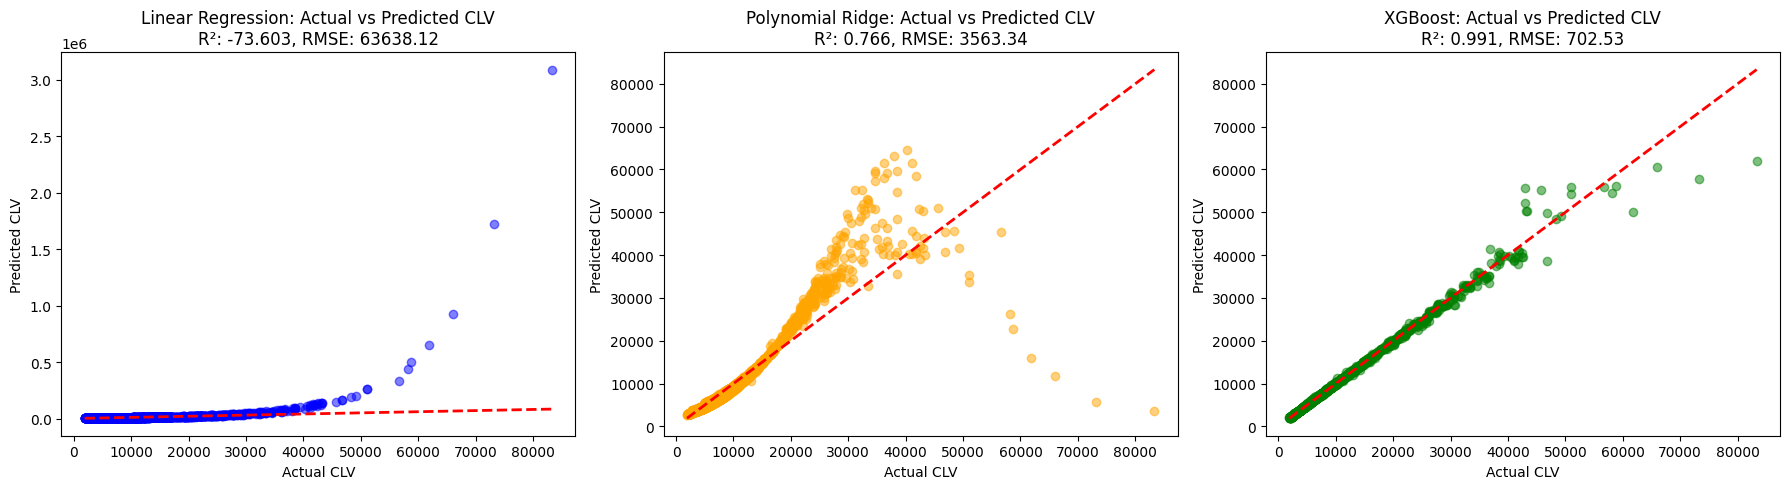

In [12]:
# 8. Visual Comparison: Actual vs Predicted CLV
plt.figure(figsize=(18, 5))

# Linear Regression
r2_lin = r2_score(y_true_lin, y_pred_lin_clv)
rmse_lin = np.sqrt(mean_squared_error(y_true_lin, y_pred_lin_clv))
plt.subplot(1, 3, 1)
plt.scatter(y_true_lin, y_pred_lin_clv, alpha=0.5, color='blue')
plt.plot([y_true_lin.min(), y_true_lin.max()],
         [y_true_lin.min(), y_true_lin.max()],
         'r--', lw=2)
plt.title(f"Linear Regression: Actual vs Predicted CLV\nR²: {r2_lin:.3f}, RMSE: {rmse_lin:.2f}")
plt.xlabel("Actual CLV")
plt.ylabel("Predicted CLV")

# Polynomial Ridge
r2_poly = r2_score(y_true_poly, y_pred_poly_clv)
rmse_poly = np.sqrt(mean_squared_error(y_true_poly, y_pred_poly_clv))
plt.subplot(1, 3, 2)
plt.scatter(y_true_poly, y_pred_poly_clv, alpha=0.5, color='orange')
plt.plot([y_true_poly.min(), y_true_poly.max()],
         [y_true_poly.min(), y_true_poly.max()],
         'r--', lw=2)
plt.title(f"Polynomial Ridge: Actual vs Predicted CLV\nR²: {r2_poly:.3f}, RMSE: {rmse_poly:.2f}")
plt.xlabel("Actual CLV")
plt.ylabel("Predicted CLV")

# XGBoost
r2_xgb = r2_score(y_true_xgb, y_pred_xgb_clv)
rmse_xgb = np.sqrt(mean_squared_error(y_true_xgb, y_pred_xgb_clv))
plt.subplot(1, 3, 3)
plt.scatter(y_true_xgb, y_pred_xgb_clv, alpha=0.5, color='green')
plt.plot([y_true_xgb.min(), y_true_xgb.max()],
         [y_true_xgb.min(), y_true_xgb.max()],
         'r--', lw=2)
plt.title(f"XGBoost: Actual vs Predicted CLV\nR²: {r2_xgb:.3f}, RMSE: {rmse_xgb:.2f}")
plt.xlabel("Actual CLV")
plt.ylabel("Predicted CLV")

plt.tight_layout()
plt.show()